# Recommend System
-------------------

# Import Libraries

In [1]:
import math
import random
import numpy as np
import pandas as pd

from keras.models import Model
from keras import backend as bd
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.engine.topology import Layer
from keras.layers.core import Dense, Lambda
from keras.layers import Input, Embedding, Flatten, Dot

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

# Load Data

In [2]:
df_ratings = pd.read_csv('data/ratings.csv')

df_items = pd.read_csv('data/items.csv')
n_items = df_items.movie_id.nunique()

df_users = pd.read_csv('data/users.csv')
n_users = df_users.user_id.nunique()

# Model Building

## Defien Model

In [15]:
def build_model(n_users, n_items, n_factors = 30):
    user_input = Input(shape=[1], name='user_input')
    item_input = Input(shape=[1], name='item_input')

    inputs = [user_input, item_input]

    user_embedding = Embedding(n_users, n_factors, name='user_embedding')(user_input)
    item_embedding = Embedding(n_items, n_factors, name='item_embedding')(item_input)

    user_flatten = Flatten(name='flatten_user_embedding')(user_embedding)
    item_flatten = Flatten(name='flatten_item_embedding')(item_embedding)

    rating = Dot(axes=1, name='dot_product')([user_flatten, item_flatten])

    model = Model(inputs, rating, name='training_model')
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

    return model

In [16]:
model = build_model(n_users, n_items)

# Training Phase

## Building Batch

In [26]:
def random_split(df, ratios):
    samples = df.shape[0]

    split_ratio = np.cumsum(ratios).tolist()[:-1]
    split_index = [round(x * samples) for x in split_ratio]
    splits = np.split(df, split_index)
    
    for i in range(len(ratios)):
        splits[i]['split_index'] = i
    
    return splits

## Traning over batches

In [27]:
BATCH_SIZE = 10
EVALUATE_EVERY = 100
NUMBER_VALIDATE = 1000
NUMBER_ITERATIONS = 2000

In [30]:
import time

try:
    model.load_weights('resources/lineal/model.h5')
    
except OSError:
    log_file = open('resources/lineal/log_training', 'w')

    log_file.write('Start training process!')
    log_file.write('---------------------------------')

    time_start = time.time()
    n_iterations = 0
    for i in range(1, NUMBER_ITERATIONS + 1):
        results, _ = random_split(df_ratings, [0.2, 0.8])
        loss = model.train_on_batch([results.user_id, results.movie_id], results.rating)
        n_iterations += 1
        if i % EVALUATE_EVERY == 0:
            log_file.write('\n--------------\n')
            log_file.write('[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}'.format(i, (time.time() - time_start)/60.0, loss, n_iterations))
        if i % (EVALUATE_EVERY * 10) == 0:    
            print(f'[{i}] ...')
    model.save_weights('resources/lineal/model.h5')



[1000] ...
[2000] ...


In [31]:
try:
    train = pd.read_csv('resources/lineal/training.csv')
except FileNotFoundError:
    train, _ = random_split(df_ratings, [0.8, 0.2])
    train.to_csv('resources/lineal/training.csv')

# Evaluation

In [34]:
model.predict([[1], [1]])

array([[4.046356]], dtype=float32)

In [35]:
model.predict([[3], [1]])

array([[2.9156291]], dtype=float32)

In [36]:
def compute_probs(model, X_user, X_item, thrs=0.5):
    m = X_user.shape[0]
    nbevaluation = int(m**2)
    X = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))

    k = 0
    for i in range(1, m):
        for j in range(1, m):
            X[k] = float(model.predict([X_user[i-1:i], X_item[j-1:j]]))
            if X[k] > thrs: y[k] = 1
            else: y[k] = 0
            k += 1
    return X, y

def compute_metrics(X, y):
    auc = roc_auc_score(y, X)
    fpr, tpr, thresholds = roc_curve(y, X)
    return fpr, tpr, thresholds, auc

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side='left')
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math .fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx

def draw_roc(fpr, tpr, threshold):
    targetfpr=1e-3
    _, idx = find_nearest(fpr, targetfpr)
    threshold = threshold[idx]
    recall = tpr[idx]

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC:{0:.3f}\nSensitivity : {2:.1f} @FPR={1:.0e}\nThreshold={3}'.format(auc, targetfpr, recall, abs(threshold)))
    plt.show()

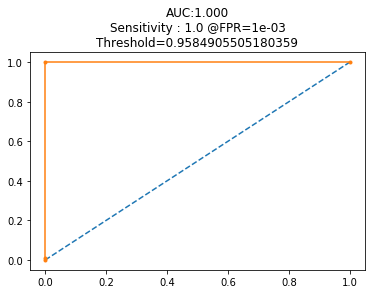

In [38]:
X, y = compute_probs(model, df_ratings.user_id[:100], df_ratings.movie_id[:100], thrs=0.02)
fpr, tpr, threshold, auc = compute_metrics(X, y)
draw_roc(fpr, tpr, threshold)

In [39]:
def get_embedding(model, name):
    embedding = model.get_layer(name = name).get_weights()[0]
    return embedding

In [41]:
item_embedding = get_embedding(model, 'item_embedding')
user_embedding = get_embedding(model, 'user_embedding')

In [43]:
def get_predictions(model, data):
    user_item = user_item_crossjoin(data)
    user_item["rating_pred"] = model.predict([user_item['user_id'], user_item['movie_id']])
    return user_item

def user_item_crossjoin(df):
    crossjoin_list = []
    for user in df['user_id'].unique():
        for item in df['movie_id'].unique():
            crossjoin_list.append([user, item])
    cross_join_df = pd.DataFrame(data=crossjoin_list, columns=["user_id", "movie_id"])
    return cross_join_df

In [45]:
try:
    predictions = pd.read_csv('resources/lineal/predictions.csv')
except FileNotFoundError:
    predictions = get_predictions(model, train)
    predictions.to_csv('resources/lineal/predictions.csv')

In [53]:
def get_top_k_items(df, col_user, col_rating, k=10):
    top_k_items = (
        df.groupby(col_user, as_index=True)
        .apply(lambda x: x.nlargest(k, col_rating))
        .reset_index(drop=True)
    )
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=True).cumcount() + 1
    return top_k_items

def recommend_topk(predictions, train, k=5):
    predictions.fillna(0, inplace=True)
    recommend_topk_df = get_top_k_items(predictions, 'user_id', 'rating_pred', k=5)
    return recommend_topk_df


In [54]:
try:
    ranking_top = pd.read_csv('resources/lineal/ranking_top.csv')
except FileNotFoundError:
    ranking_top = recommend_topk(predictions, train)
    ranking_top.to_csv('resources/lineal/ranking_top.csv')

In [58]:
def get_hit_df(rating_true, rating_pred, k):
    common_users = set(rating_true["user_id"]).intersection(set(rating_pred["user_id"]))
    rating_true_common = rating_true[rating_true["user_id"].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred["user_id"].isin(common_users)]
    n_users = len(common_users)
    df_hit = get_top_k_items(rating_pred_common, "user_id", "rating_pred", k)
    df_hit = pd.merge(df_hit, rating_true_common, on=["user_id", "movie_id"])[
        ["user_id", "movie_id", "rank"]
    ]
    df_hit_count = pd.merge(
        df_hit.groupby("user_id", as_index=False)["user_id"].agg({"hit": "count"}),
        rating_true_common.groupby("user_id", as_index=False)["user_id"].agg(
            {"actual": "count"}
        ),
        on="user_id",
    )
    return df_hit, df_hit_count, n_users

def precision_at_k(rating_true, rating_pred, k):
    df_hit, df_hit_count, n_users = get_hit_df(rating_true, rating_pred, k)
    if df_hit.shape[0] == 0:
        return 0.0
    return (df_hit_count["hit"] / k).sum() / n_users

def recall_at_k(rating_true, rating_pred, k):
    df_hit, df_hit_count, n_users = get_hit_df(rating_true, rating_pred, k)
    if df_hit.shape[0] == 0:
        return 0.0
    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

def ndcg_at_k(rating_true, rating_pred, k):
    df_hit, df_hit_count, n_users = get_hit_df(rating_true, rating_pred, k)
    if df_hit.shape[0] == 0:
        return 0.0
    df_dcg = df_hit.copy()
    df_dcg["dcg"] = 1 / np.log1p(df_dcg["rank"])
    df_dcg = df_dcg.groupby("user_id", as_index=False, sort=False).agg({"dcg": "sum"})
    df_ndcg = pd.merge(df_dcg, df_hit_count, on=["user_id"])
    df_ndcg["idcg"] = df_ndcg["actual"].apply(
        lambda x: sum(1 / np.log1p(range(1, min(x, k) + 1)))
    )
    return (df_ndcg["dcg"] / df_ndcg["idcg"]).sum() / n_users

In [59]:
eval_precision = precision_at_k(train[:100], ranking_top, k=10)
eval_recall = recall_at_k(train[:100], ranking_top, k=10)
eval_ndcg = ndcg_at_k(train[:100], ranking_top, k=10)

print(
    f' NDCG_K:\t{eval_ndcg}\n', 
    f'Recall_K:\t{eval_recall}\n'
    f' Precision_K:\t{eval_precision}\n', 
)

 NDCG_K:	0.22009176629808014
 Recall_K:	0.01
 Precision_K:	0.1



# Get Similar Items

In [60]:
def get_similar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(embedding)
    distance, indece = model_similar_items.kneighbors(embedding)
    return distance, indece

In [61]:
item_distance, item_similar_indice = get_similar(item_embedding, 5)
item_similar_indice

array([[   0, 1462, 1438, 1637, 1535],
       [   1, 1293,  100,  915, 1272],
       [   2,  723, 1157,  291, 1049],
       ...,
       [1679, 1593, 1123, 1370, 1190],
       [1680, 1383, 1511, 1347, 1661],
       [1681, 1327, 1523, 1253, 1511]], dtype=int64)

In [62]:
def print_similar(item_index, item_similar_indices, df):
    encode_df = df.copy()
    item_encode = LabelEncoder()
    item_encode.fit(encode_df.movie_id.values)
        
    s = item_similar_indices[item_index]
    movie_ids = item_encode.inverse_transform(s)

    print(movie_ids)

print_similar(0, item_similar_indice, df_items)

[   1 1463 1439 1638 1536]
